# Importing Libraries

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import joblib

from wordcloud import WordCloud
from collections import Counter

# Data Proprocessing

## Loading Data

Load the data, and have an overview of the dataset

In [139]:
data = pd.read_csv('Suicide_Detection.csv')

print(data.head(),"\n")
print(data.info(),"\n")
print("Shape: ",data.shape)

# Convert suicide value to binary values
data['is_suicide'] = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
None 

Shape:  (232074, 3)


The column 'Unnammed: 0' is not needed, we can delete the redundant column

In [3]:
data.drop(columns = 'Unnamed: 0', inplace=True)
data.head()

,text,class,is_suicide
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,Am I weird I don't get affected by compliments...,non-suicide,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1


Check is null values exist

In [4]:
data.isnull().sum()

text          0
class         0
is_suicide    0
dtype: int64

### Features Engineering

In [5]:
data['total_words'] = data['text'].apply(lambda x: len(x.split()))
data.head()

,text,class,is_suicide,total_words
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143
1,Am I weird I don't get affected by compliments...,non-suicide,0,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26
3,i need helpjust help me im crying so hard,suicide,1,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438


## Data Visualization

Proportion of suicide and non-suicide thoughts

1    116037
0    116037
Name: is_suicide, dtype: int64


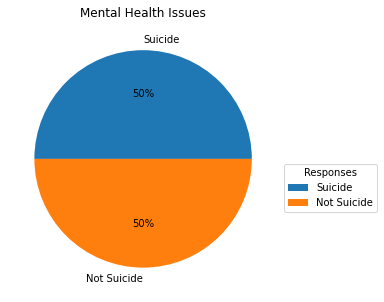

In [6]:
classCount = data["is_suicide"].value_counts()
print(classCount)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
plt.title('Mental Health Issues')
plt.pie(classCount, labels=['Suicide', 'Not Suicide'], autopct='%.0f%%')

# Add a legend outside the pie chart
plt.legend(title="Responses", loc="upper left", bbox_to_anchor=(1, 0.5))

# Add a legend outside the pie chart

plt.show()

## Text Processing

Lower Case, Remove Puncutuations, Remove Stop Words

In [7]:
# Convert texts to lower case
data['preprocessed_text'] = data['text'].str.lower()

# Remove punctuations
data['preprocessed_text'] = data['preprocessed_text'].str.replace(r'[^\w\s]+','',regex=True)

# Remove stop words
stop_words = stopwords.words('english')
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenize the words
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x:nltk.word_tokenize(x))

### Lemmatization

In [8]:
# Lemmatize the words
lemmatizer = WordNetLemmatizer()
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: [lemmatizer.lemmatize(word,pos='v') for word in x])

# Combine the words
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: ' '.join(x))

data.head()

,text,class,is_suicide,total_words,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143,ex wife threaten suiciderecently leave wife go...
1,Am I weird I don't get affected by compliments...,non-suicide,0,27,weird dont get affect compliment come someone ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26,finally 2020 almost never hear 2020 bad year e...
3,i need helpjust help me im crying so hard,suicide,1,9,need helpjust help im cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438,im losthello name adam 16 ive struggle years i...


Check null values after preprocessing process

In [9]:
data.isnull().sum()

text                 0
class                0
is_suicide           0
total_words          0
preprocessed_text    0
dtype: int64

Save preprocessed works to new csv file

In [10]:
data['preprocessed_text'] = data['preprocessed_text'].astype(str)
data.dropna(inplace=True)
data.to_csv('preprocessed.csv')

In [140]:
preprocessed_data = pd.read_csv('preprocessed.csv')
preprocessed_data.dropna(inplace=True)
preprocessed_data.head()

,Unnamed: 0,text,class,is_suicide,total_words,preprocessed_text
0,0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143,ex wife threaten suiciderecently leave wife go...
1,1,Am I weird I don't get affected by compliments...,non-suicide,0,27,weird dont get affect compliment come someone ...
2,2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26,finally 2020 almost never hear 2020 bad year e...
3,3,i need helpjust help me im crying so hard,suicide,1,9,need helpjust help im cry hard
4,4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438,im losthello name adam 16 ive struggle years i...


### Words Frequency

show words commonly used when expressing suicidal thought

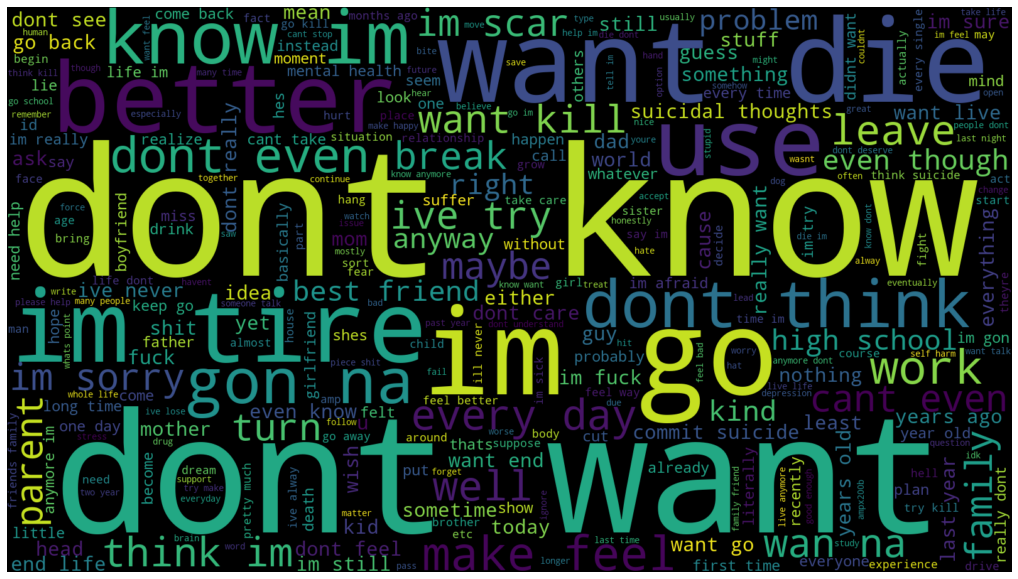

In [141]:
# Generate word cloud of suicidal thoughts
preprocessed_data['preprocessed_text'] = preprocessed_data['preprocessed_text'].astype(str)

suicidal_thoughts = " ".join(preprocessed_data[preprocessed_data['is_suicide'] == 1]['preprocessed_text'])

plt.figure(figsize=(18,12))
wordcloud = WordCloud(max_words = 300, height = 900, width = 1600, background_color='black',colormap='viridis').generate(suicidal_thoughts)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

show the ranking of words of suicidal thought

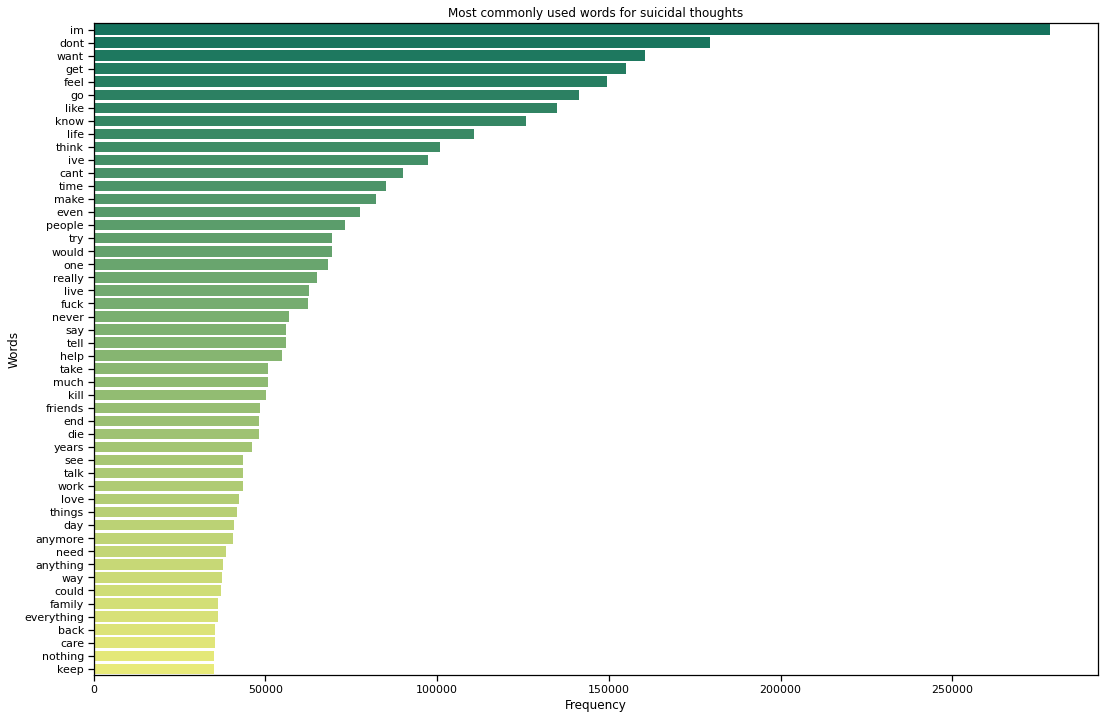

In [142]:
depression_words_ranking = []
for sentence in preprocessed_data[preprocessed_data['is_suicide'] == 1]['preprocessed_text'].to_list():
    for word in sentence.split():
        depression_words_ranking.append(word)
        
df = pd.DataFrame(Counter(depression_words_ranking).most_common(50),columns=['Word','Frequency'])

sns.set_context('notebook')
plt.figure(figsize=(18,12))
sns.barplot(y=df['Word'], x=df['Frequency'],palette='summer')
plt.title('Most commonly used words for suicidal thoughts')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Comparions of Original word & Preprocessed word

In [143]:
preprocessed_data[['text','preprocessed_text']]

,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threaten suiciderecently leave wife go...
1,Am I weird I don't get affected by compliments...,weird dont get affect compliment come someone ...
2,Finally 2020 is almost over... So I can never ...,finally 2020 almost never hear 2020 bad year e...
3,i need helpjust help me im crying so hard,need helpjust help im cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",im losthello name adam 16 ive struggle years i...
...,...,...
232069,If you don't like rock then your not going to ...,dont like rock go get anything go httpsmusicta...
232070,You how you can tell i have so many friends an...,tell many friends lonely everything deprive pr...
232071,pee probably tastes like salty tea😏💦‼️ can som...,pee probably taste like salty tea someone drin...
232072,The usual stuff you find hereI'm not posting t...,usual stuff find hereim post sympathy pity kno...


# Training Models

### Splitting Data

For training the dataset and make predictions

In [4]:
x,y = preprocessed_data['preprocessed_text'],preprocessed_data['is_suicide']

vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x = vectorizer.fit_transform(x).toarray()

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=3)
X_train.shape, X_test.shape

((185633, 5000), (46409, 5000))

## Naive Bayes

Naive bayes with voting classifier

In [100]:
nb_gaussian = GaussianNB()
nb_bernoulli = BernoulliNB()
nb_multinomial = MultinomialNB()

nb_classifier = VotingClassifier(
    estimators=[
        ('GaussianNB',nb_gaussian),
        ('Bernoulli',nb_bernoulli),
        ('Multinomial',nb_multinomial)
    ],voting='soft',verbose=1
)

VotingClassifiers.fit(X_train,y_train)

nb_prediction = nb_classifier.predict(X_test)
nb_confusion_matrix = confusion_matrix(y_test,nb_prediction)
nb_accuracy = accuracy_score(y_test,nb_prediction)

print("Naive Bayes\n=====================\n")

# Score for Training
print("Training Score = ",nb_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",nb_classifier.score(X_test,y_test))

# Confusion Matrix
print("\n\nConfusion Matrix : ", nb_confusion_matrix)

print(classification_report(y_test,nb_prediction))

MemoryError: Unable to allocate 6.92 GiB for an array with shape (185633, 5000) and data type float64

## Logistic Regression

In [144]:
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train,y_train)

lr_prediction = lr_classifier.predict(X_test)
lr_confusion_matrix = confusion_matrix(y_test,lr_prediction)
lr_accuracy = accuracy_score(y_test,lr_prediction)

print("Logistic Regression\n=====================\n")

# Score for Training
print("Training Score = ",lr_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",lr_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", lr_confusion_matrix)

print(classification_report(y_test,lr_prediction))

Logistic Regression

Training Score =  0.9384915397585558
Testing Score =  0.9335904673662436

Confusion Matrix :  [[21956  1308]
 [ 1774 21371]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     23264
           1       0.94      0.92      0.93     23145

    accuracy                           0.93     46409
   macro avg       0.93      0.93      0.93     46409
weighted avg       0.93      0.93      0.93     46409



## Random Forest

In [96]:
random_forest_classifier = RandomForestClassifier(n_estimators=40,random_state=20,verbose=1)

random_forest_classifier.fit(X_train,y_train)

rf_prediction = random_forest_classifier.predict(X_test)
rf_confusion_matrix = confusion_matrix(y_test,rf_prediction)
rf_accuracy = accuracy_score(y_test,rf_prediction)

print("Random Forest\n=====================\n")

# Score for Training
print("Training Score = ",random_forest_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",random_forest_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", rf_confusion_matrix)

print(classification_report(y_test,rf_prediction))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 17.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   10.3s finished


Training Score =  0.998895670489622


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Testing Score =  0.9021310521666056

Confusion Matrix :  [[20757  2507]
 [ 2035 21110]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     23264
           1       0.89      0.91      0.90     23145

    accuracy                           0.90     46409
   macro avg       0.90      0.90      0.90     46409
weighted avg       0.90      0.90      0.90     46409



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.4s finished


## Decision Tree

In [125]:
decision_tree_classifier = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=200,max_depth=9,random_state=2)
decision_tree_classifier.fit(X_train,y_train)

dt_prediction = decision_tree_classifier.predict(X_test)
dt_confusion_matrix = confusion_matrix(y_test,dt_prediction)
dt_accuracy = accuracy_score(y_test,dt_prediction)
                    
print("Decision Tree\n=====================\n")
# Score for Training
print("Training Score = ",decision_tree_classifier.score(X_train,y_train))
                             
# Score for Testing
print("Testing Score = ",decision_tree_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", dt_confusion_matrix)

print(classification_report(y_test,dt_prediction))

KeyboardInterrupt: 

## Support Vector Machines (SVM)

In [ ]:
svm_classifier = SVC(kernel='linear')

svm_classifier.fit(X_train,y_train)

svm_prediction = svm_classifier.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_test,svm_prediction)
svm_accuracy = accuracy_score(y_test,svm_prediction)

# Score for Training
print("Training Score = ",svm_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",svm_classifier.score(X_test,y_test))

# Confusion Matrix
print("\nConfusion Matrix : ", svm_confusion_matrix)

print(classification_report(y_test,svm_prediction))

# Conclusion

Sorting models' accuracies

In [108]:
model_ev = pd.DataFrame({
    'Model':['Naive Bayes','Random Forest','Logistic Regression','Decision Tree'],
    'Accuracy':[nb_accuracy,rf_accuracy,lr_accuracy,dt_accuracy]
})

model_ev.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy
2,Logistic Regression,0.933590
1,Random Forest,0.902131
0,Naive Bayes,0.900041
3,Decision Tree,0.811696


<b><i>Logistic Regression</i></b> is the best fit model for the given dataset as it has the values,
- Accuracy Score: 0.933590

With confusion matrix:

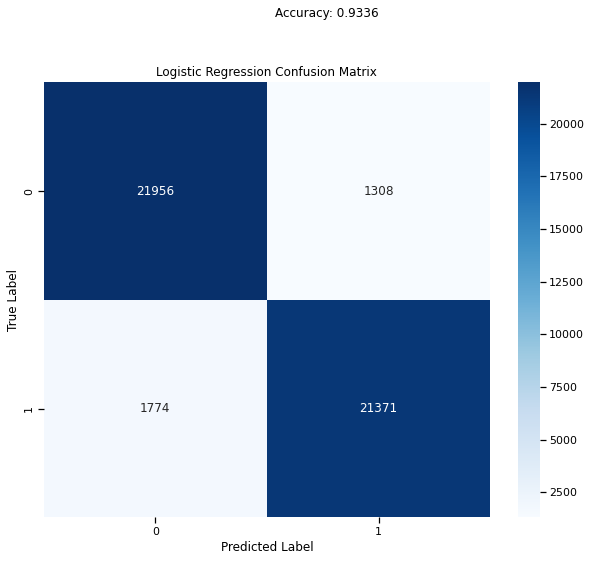

In [156]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(lr_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.text(1.5, -0.3, f'Accuracy: {lr_accuracy:.4f}', fontsize=12, ha='right')
plt.show()

## Save Model

Save the best model (Linear Regression) to a joblib file

In [6]:
joblib.dump(lr_classifier,'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [134]:
# Load the best model
logistic_regression_model = joblib.load('logistic_regression_model.joblib')

def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = text.replace(r'[^\w\s]+','')
    word = ' '.join([lemmatizer.lemmatize(i, pos='v') for i in word_tokenize(text) if i not in stop_words])
    return vectorizer.transform([word]).toarray()

def mental_health_issue_detector(text):
    print("Input = ",text)
    processed_word = preprocess(text)
    prediction = logistic_regression_model.predict(processed_word)
    print("Result : ", "Non-depressed" if prediction[0] == 0 else "Depressed")

## Predicting Result for User Input

Getting text inputs from text file

In [154]:
mental_health_issue_detector("""
   I'm getting evicted on Friday, and my ex won custody of my son. All the good things in my life are leaving me. I thought I could keep strength through it all. But I'm just a worthless nobody who can't even right his wrongs. I love my son more than life, and now I'm not going to see him for a long time. I just got a job and it raised up my hopes, but I lost all my motivation knowing I won't wake up my son's laughter or cry in the morning. I used to find it annoying sometimes and now I'll do anything to get it back. Idk if my landlord will care that I got another job and wait for my check Monday to come. But I plan on doing it when I'm forcefully removed from the house. I deserve to die. I've been with my son through it all, and all of a sudden I'm not in position to care for him because I'm going through a slump? I try, cry, and give my all for him. And now none if it matters. I just want to sleep and never wake up again. God please lift me from this hell. I brought him in this world. I don't want to go without raising him or being there in moments he needs me. But how does it all work? I cut my wrists today and felt so selfish. But me being gone seems like the best future for myself. I just can't shake this feeling. I really need help.
""")

Input =  
   I'm getting evicted on Friday, and my ex won custody of my son. All the good things in my life are leaving me. I thought I could keep strength through it all. But I'm just a worthless nobody who can't even right his wrongs. I love my son more than life, and now I'm not going to see him for a long time. I just got a job and it raised up my hopes, but I lost all my motivation knowing I won't wake up my son's laughter or cry in the morning. I used to find it annoying sometimes and now I'll do anything to get it back. Idk if my landlord will care that I got another job and wait for my check Monday to come. But I plan on doing it when I'm forcefully removed from the house. I deserve to die. I've been with my son through it all, and all of a sudden I'm not in position to care for him because I'm going through a slump? I try, cry, and give my all for him. And now none if it matters. I just want to sleep and never wake up again. God please lift me from this hell. I brought him in 